In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

2023-05-18 02:10:17.177511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 02:10:17.311648: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 02:10:17.942661: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andres/installROOT/lib
2023-05-18 02:10:17.942795: W tensorflow/compiler/xla/stre

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [5]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 50

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

In [6]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
17206
17206
17206
17206
17206
17206
17206
17206

 Signal Events
12157
12157
12157
12157
12157
12157
12157
12157


In [7]:
#############################
# ONLY peakS2_onlyhits DATA #
#############################

# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
num_data = 10000


# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_S = 0

for i in range(1, num_data+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    

# close the h5 files
f_B.close()
f_S.close()

    
    

# X and Y for the classifier
X_mon = np.row_stack([peakS2_onlyhits_B,peakS2_onlyhits_S])
# normalize
X_mon = scaler.fit_transform(X_mon)

del peakS2_onlyhits_B
del peakS2_onlyhits_S

# labels
y_mon = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

max_pS2_both lenght:  2244

X_mon_train :  (9999, 2244)
y_mon_train :  (9999,)
X_mon_val :  (3334, 2244)
y_mon_val :  (3334,)
X_mon_test :  (6667, 2244)
y_mon_test :  (6667,)



### CLASSIFIER

/home/andres/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.11681	validation_0-logloss:0.63129	validation_0-map:0.90842	validation_1-error:0.14037	validation_1-logloss:0.63496	validation_1-map:0.89374
[1]	validation_0-error:0.10721	validation_0-logloss:0.57997	validation_0-map:0.92015	validation_1-error:0.13017	validation_1-logloss:0.58733	validation_1-map:0.91288
[2]	validation_0-error:0.10421	validation_0-logloss:0.53610	validation_0-map:0.93619	validation_1-error:0.12897	validation_1-logloss:0.54688	validation_1-map:0.92253
[3]	validation_0-error:0.09901	validation_0-logloss:0.49919	validation_0-map:0.94709	validation_1-error:0.12627	validation_1-logloss:0.51354	validation_1-map:0.92685
[4]	validation_0-error:0.09671	validation_0-logloss:0.46717	validation_0-map:0.95326	validation_1-error:0.12388	validation_1-logloss:0.48438	validation_1-map:0.93064
[5]	validation_0-error:0.09471	validation_0-logloss:0.43915	validation_0-map:0.95593	validation_1-error:0.12388	validation_1-logloss:0.45971	validation_1-map:0.93164
[6]	

[50]	validation_0-error:0.06191	validation_0-logloss:0.16807	validation_0-map:0.98601	validation_1-error:0.11488	validation_1-logloss:0.27242	validation_1-map:0.94956
[51]	validation_0-error:0.06121	validation_0-logloss:0.16724	validation_0-map:0.98616	validation_1-error:0.11488	validation_1-logloss:0.27246	validation_1-map:0.94966
[52]	validation_0-error:0.06081	validation_0-logloss:0.16584	validation_0-map:0.98664	validation_1-error:0.11578	validation_1-logloss:0.27218	validation_1-map:0.94996
[53]	validation_0-error:0.06061	validation_0-logloss:0.16521	validation_0-map:0.98677	validation_1-error:0.11638	validation_1-logloss:0.27227	validation_1-map:0.94996
[54]	validation_0-error:0.06041	validation_0-logloss:0.16342	validation_0-map:0.98740	validation_1-error:0.11518	validation_1-logloss:0.27223	validation_1-map:0.95004
[55]	validation_0-error:0.06001	validation_0-logloss:0.16215	validation_0-map:0.98777	validation_1-error:0.11398	validation_1-logloss:0.27190	validation_1-map:0.9502

[100]	validation_0-error:0.03590	validation_0-logloss:0.12514	validation_0-map:0.99540	validation_1-error:0.11398	validation_1-logloss:0.27263	validation_1-map:0.95005
[101]	validation_0-error:0.03540	validation_0-logloss:0.12484	validation_0-map:0.99544	validation_1-error:0.11368	validation_1-logloss:0.27260	validation_1-map:0.95006
[102]	validation_0-error:0.03490	validation_0-logloss:0.12431	validation_0-map:0.99553	validation_1-error:0.11338	validation_1-logloss:0.27285	validation_1-map:0.95000
[103]	validation_0-error:0.03370	validation_0-logloss:0.12265	validation_0-map:0.99577	validation_1-error:0.11398	validation_1-logloss:0.27321	validation_1-map:0.94973
[104]	validation_0-error:0.03360	validation_0-logloss:0.12220	validation_0-map:0.99582	validation_1-error:0.11428	validation_1-logloss:0.27351	validation_1-map:0.94963
[105]	validation_0-error:0.03330	validation_0-logloss:0.12165	validation_0-map:0.99586	validation_1-error:0.11428	validation_1-logloss:0.27390	validation_1-map:

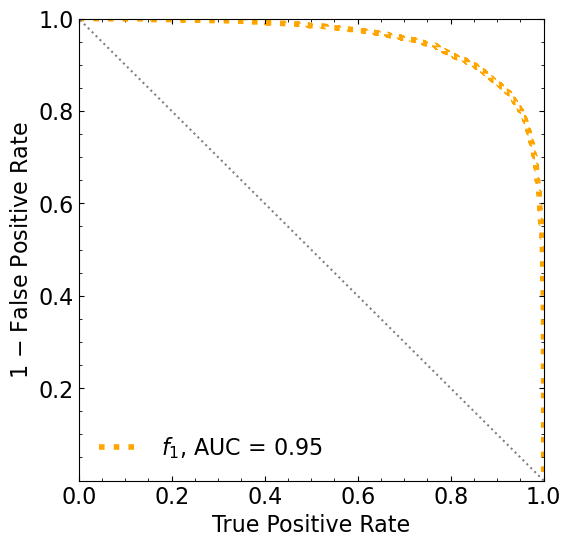

In [8]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric=["error", "logloss", "map"],early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

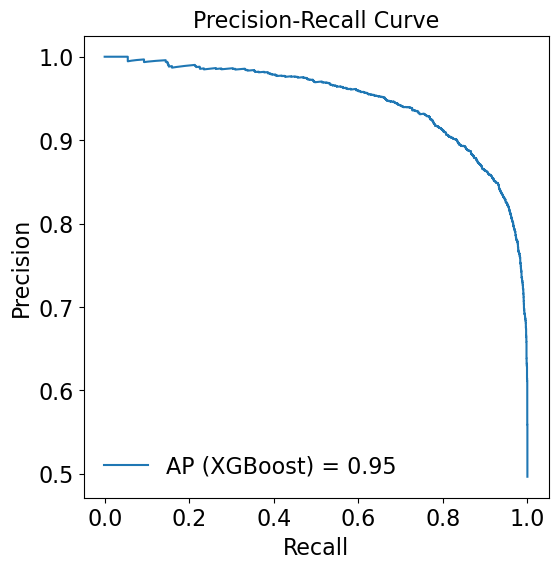

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_xg, recall_xg, _ = precision_recall_curve(y_mon_test, y_pred_xg)
auc_xg = auc(recall_xg, precision_xg)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_xg, precision_xg, label=f'AP (XGBoost) = {auc_xg:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

Accuracy: 88.05%


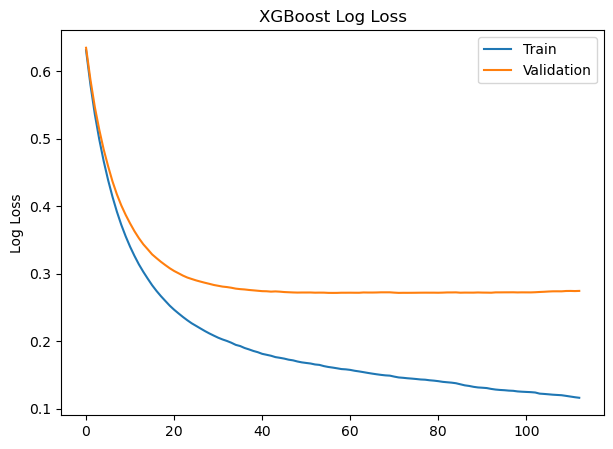

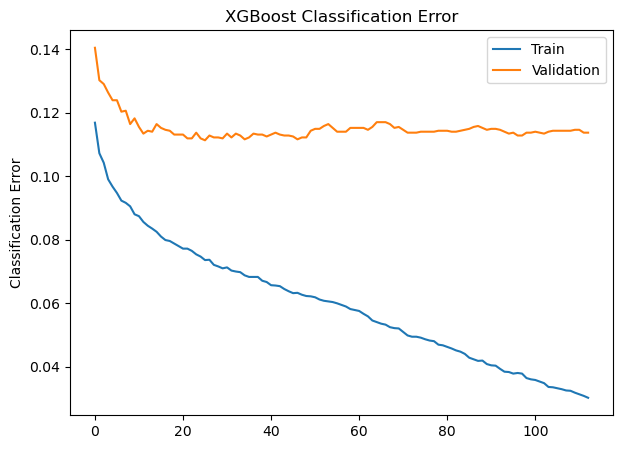

In [10]:
predictions = [round(value) for value in y_pred_xg]
accuracy = accuracy_score(y_mon_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)


# plot log loss
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

Classification score:


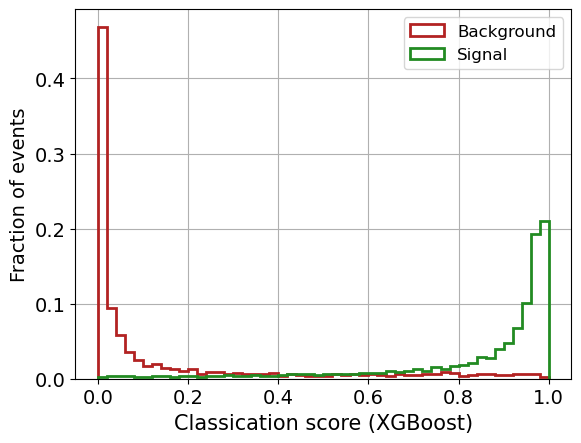

In [11]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()